# Standard Supervised Learning (No PCA)

In [29]:
import numpy as np
import pandas as pd

import datetime

notebook_start_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_start_time}")

Notebook last run (end-to-end): 2025-02-05 00:09:24.857816


In [30]:
df = pd.read_csv("../data/high_diamond_ranked_10min.csv")

# See 0 Exploratory Analysis notebook for reasoning
drop_columns = ['gameId', 'blueEliteMonsters', 'redEliteMonsters', 'redGoldDiff', 'redExperienceDiff', 'blueGoldPerMin', 'redGoldPerMin', 'redFirstBlood', 'redDeaths', 'blueDeaths']
df = df.drop(columns=drop_columns)
df

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,...,redAssists,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redCSPerMin
0,0,28,2,1,9,11,0,0,0,17210,...,8,0,0,0,16567,6.8,17047,197,55,19.7
1,0,12,1,0,5,5,0,0,0,14712,...,2,1,1,1,17620,6.8,17438,240,52,24.0
2,0,15,0,0,7,4,1,0,0,16113,...,14,0,0,0,17285,6.8,17254,203,28,20.3
3,0,43,1,0,4,5,0,1,0,15157,...,10,0,0,0,16478,7.0,17961,235,47,23.5
4,0,75,4,0,6,6,0,0,0,16400,...,7,1,0,0,17404,7.0,18313,225,67,22.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,17,2,1,7,5,1,0,0,17765,...,7,0,0,0,15246,6.8,16498,229,34,22.9
9875,1,54,0,0,6,8,1,0,0,16238,...,3,0,0,0,15456,7.0,18367,206,56,20.6
9876,0,23,1,0,6,5,0,0,0,15903,...,11,1,0,0,18319,7.4,19909,261,60,26.1
9877,0,14,4,1,2,3,1,0,0,14459,...,1,0,0,0,15298,7.2,18314,247,40,24.7


In [31]:
print(f"Number of features (columns): {len(df.columns)}")
print(f"Number of samples (rows): {len(df)}")

Number of features (columns): 30
Number of samples (rows): 9879


### Setting Expectations: Missing Features and Expected Accuracy

We don't have data about individual champions on each team (or champion's winrate), information about each player's ELO (which has surprisingly high variance), information about how long each player was in game (a player who connects late or disconnects early will obviously have a huge influence on the game), or even more granular data like player positions or item purchases. Predicting games based on data like player movement and item buys would likely be difficult (especially without enormous amounts of data). Predictions based on team composition is out of the question, with so many possible different team combinations (and team matchups) that getting even one game per possible combination of champions would require astronomical amounts of data. None of this data is available without making additional queries to Riot's API, so this is all to say these features would probably not be useful even if we did know them.

However, we are lacking three major pieces of data.
1. We don't have information beyond the first ten minutes of each game. Both of these have enormous impacts on target accuracy for our model and the kinds of models we can train. As for having only ten minutes of data, this means we're only seeing the very beginnings of the game, while it's still in the first phase ("laning phase"). This means we are only able to predict game outcomes based on very early leads. However, team performance is not time homogenous, like in football: a football team scoring does not make it any easier or harder for them to score, so we could reasonably model football goals as independent. However, a player in League of Legends dying or performing poorly puts them at a disadvantage, increasingly the likelihood that they will continue to do poorly. This is good news for us: not only does performance in the first ten minutes predict player skill which predicts win likelihood, it actually predicts the likelihood of a team continuing to do poorly and eventually losing. Of course, by design there are frequent opportunities for teams to claw their way back into the game and make up for earlier disadvantages. We can conclude that the first ten minutes provides an imperfect but reasonably predictive window into a particular game.
2. Second, and the data we do have access to is not time series data. Having time series data would provide substantially more information into the game state: for example, all players on one team dying at the same time, or one player dying right before an objective spawns on the map, is devastating compared to dying individually at different times or dying at an relatively inconsequential time. However, time series data might also be substantially trickier to analyze accurately given the highly non-independent nature of events such as deaths, towers, gold, elite monsters, and so on. Furthermore, if we did have access to champions picks for each team, the winrates of each champion changes over time (as do many other aspects of the game) as some champions use game resources more effectively than others at certain points in the game.
3. We don't have any access to the distribution of resources. Resources like gold and experience are not shared across teams: one player on a team might have a lot of resources, and another might have very few. A single player getting a large resource lead is very different from a whole team get a moderate but evenly distributed lead. This, combined with champion data (some of which obtain or use resources better or worse than others), would vastly improve model accuracy and better identify games where one team can run away with a lead. Resource lead also can't tell us how well a team uses resources, or how many resources they need to succeed: some games that have 0 gold difference may strongly favor one team over another.  

In light of all this, I would consider accurate above 85% to be highly suspect and likely an indication of overfitting or some kind of bias. On the other hand, the information we do have should allow us to do substantially better than a coin flip: any worse than 65% would be disappointing. To summarize, **our target accuracy is between 65-85%.**

# Supervised Learning

### Train Test Split

In [32]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

y = df['blueWins']
X = df.drop(columns=['blueWins'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = X_train_scaler.transform(X_train)

### Logistic Regression

In [33]:
from sklearn import linear_model

reg = linear_model.LogisticRegression()

reg.fit(X_train_scaled, y_train)

logistic_regression_accuracy = accuracy_score(y_test, reg.predict(X_test))

print(f"Accuracy of logistic regression: {logistic_regression_accuracy:.3f}")

Accuracy of logistic regression: 0.703


/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### Linear Discriminant Analysis

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
lda_accuracy = accuracy_score(y_test, lda.predict(X_test))
print(f"Accuracy of linear discriminant analysis: {lda_accuracy:.3f}")

Accuracy of linear discriminant analysis: 0.704


/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(


### Quadratic Discriminant Analysis

In [35]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)
qda_accuracy = accuracy_score(y_test, qda.predict(X_test))
print(f"Accuracy of quadratic discriminant analysis: {qda_accuracy:.3f}")

/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Accuracy of quadratic discriminant analysis: 0.518


/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but QuadraticDiscriminantAnalysis was fitted without feature names
  warnings.warn(


In [36]:
# Covariance matrix of class 0 and 1 aren't full, so try increasing regularization
qda = QuadraticDiscriminantAnalysis(reg_param=1)
qda.fit(X_train_scaled, y_train)
qda_accuracy = accuracy_score(y_test, qda.predict(X_test))
print(f"Accuracy of quadratic discriminant analysis with regularization: {qda_accuracy:.3f}")

Accuracy of quadratic discriminant analysis with regularization: 0.729


/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but QuadraticDiscriminantAnalysis was fitted without feature names
  warnings.warn(


Regularization parameters from $0.1, 0.2, ..., 1.0$ yielded much better accuracy, capping out at $1.0$. So far, QDA is our **most accurate model**!

### Support Vector Machine

In [37]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train_scaled, y_train)
svm_accuracy = accuracy_score(y_test, clf.predict(X_test))
print(f"Accuracy of support vector machine: {svm_accuracy:.3f}")

/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Accuracy of support vector machine: 0.503


SVM accuracy is really terrible -- basically a coin flip!

### Artifical Neural Nets

In [38]:
# Set random seed
import tensorflow as tf
tf.random.set_seed(42)

In [39]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])
history = model_1.fit(X_train, y_train, epochs=20, verbose=1)
loss, accuracy = model_1.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5015 - loss: nan     
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan  
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.5028 - loss: nan
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.5028 - loss: nan
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.5028 - loss: nan
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.5028 - loss: nan
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.5028 - loss: nan
Epoch 9/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.5028 - loss: nan
Epoch 10/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.5028 - loss: nan
Epoch 11/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.5028 - loss: nan
Epoch 12/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accur

In [40]:
# First model had NaN loss, maybe learning rate is too low
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.SGD(learning_rate=0.02), metrics=['accuracy'])
history = model_2.fit(X_train, y_train, epochs=20, verbose=1)
loss, accuracy = model_2.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5015 - loss: nan      
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5028 - loss: nan
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5028 - loss: nan
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss: nan
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5028 - loss: nan
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5028 - loss: nan
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5028 - loss: nan
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5028 - loss: nan
Epoch 9/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5028 - loss: nan
Epoch 10/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5028 - loss: nan
Epoch 11/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5028 - loss: nan
Epoch 12/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5028 - loss:

In [41]:
# Adjusting learning rate did nothing, try Adam
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history = model_3.fit(X_train, y_train, epochs=20, verbose=1)
loss, accuracy = model_3.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6386 - loss: 291.9348
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6431 - loss: 62.9380
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6449 - loss: 54.7504
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6425 - loss: 40.1566
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6493 - loss: 28.2590
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6452 - loss: 36.1144
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6399 - loss: 40.7308
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6432 - loss: 48.2623
Epoch 9/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6498 - loss: 41.3957
Epoch 10/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6517 - loss: 28.6378
Epoch 11/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6447 - loss: 38.7109
Epoch 12/20
247/247 ━━━━━━━━━━━━━━━━━━━━

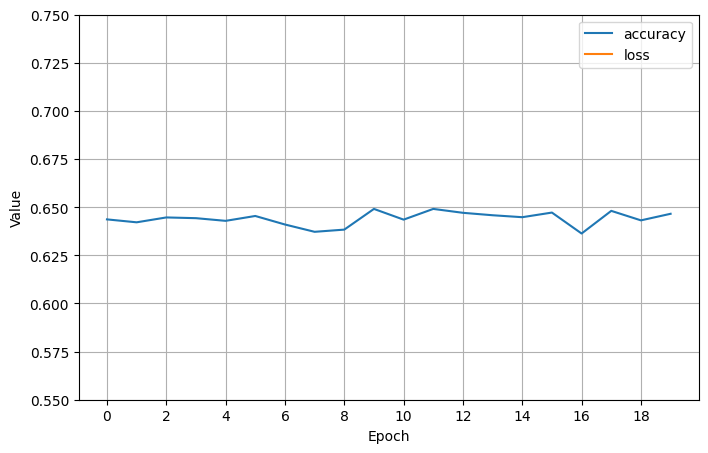

In [42]:
# We now have actual loss, so let's plot it
import seaborn as sns
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.55, 0.75)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 20, 2.0))
plt.show()


In [43]:
# See if accuracy increases with more epochs
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history = model_4.fit(X_train, y_train, epochs=100, verbose=1)
loss, accuracy = model_4.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5945 - loss: 1459.8932
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6444 - loss: 20.0031
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6416 - loss: 21.3752
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6296 - loss: 26.7336
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6371 - loss: 19.5282
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6289 - loss: 19.2805
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6487 - loss: 18.8053
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6379 - loss: 26.2303
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6402 - loss: 17.9410
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6340 - loss: 15.7664
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6392 - loss: 18.0656
Epoch 12/100
247/247 ━━━━━━━

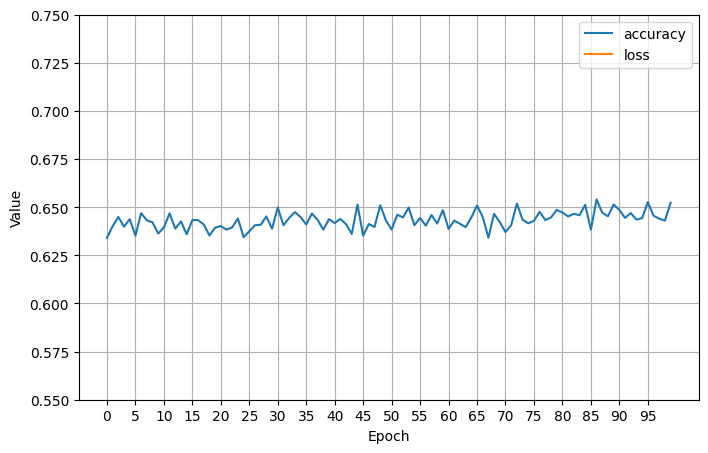

In [44]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.55, 0.75)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 100, 5.0))
plt.show()

In [45]:
# See if accuracy increases with additional nonlinear layers
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history = model_4.fit(X_train, y_train, epochs=100, verbose=1)
loss, accuracy = model_4.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6103 - loss: 73.4014
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6351 - loss: 9.6037
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6409 - loss: 8.4223
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6529 - loss: 7.0888
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6374 - loss: 4.0842
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6290 - loss: 3.9373
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6386 - loss: 3.3874
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6435 - loss: 2.5510
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6330 - loss: 2.1545
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6461 - loss: 2.0160
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6578 - loss: 1.4701
Epoch 12/100
247/247 ━━━━━━━━━━━━━━━━━━━

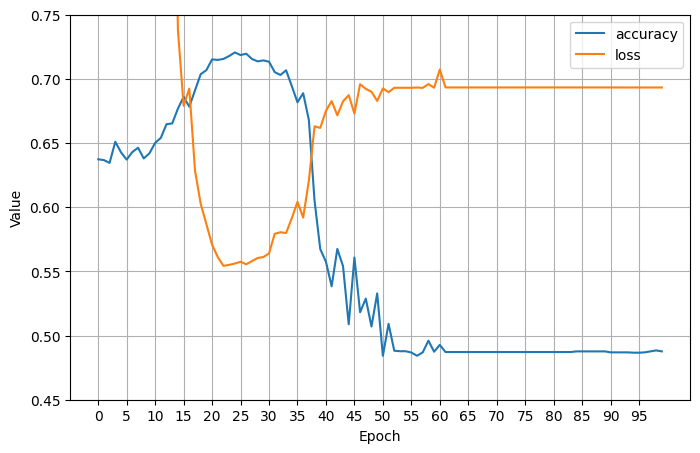

In [46]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.45, 0.75) # adjust y-axis to see full range
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 100, 5.0))
plt.show()

In [47]:
# Accuracy increased then decreased. See if smaller learning rate helps
model_5 = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
history = model_5.fit(X_train, y_train, epochs=100, verbose=1)
loss, accuracy = model_5.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5607 - loss: 214.2920
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6290 - loss: 10.7717
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6316 - loss: 7.9197
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6391 - loss: 5.2920
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6317 - loss: 4.3950
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6346 - loss: 5.2598
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6431 - loss: 3.4003
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6303 - loss: 2.9651
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6347 - loss: 3.2300
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6471 - loss: 2.5417
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6382 - loss: 1.6207
Epoch 12/100
247/247 ━━━━━━━━━━━━━━━━━

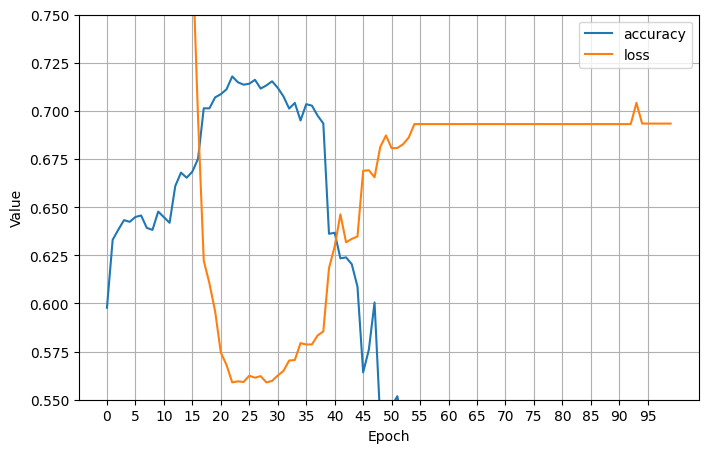

In [48]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.55, 0.75)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 100, 5.0))
plt.show()

In [49]:
# See if even smaller learning rate helps
model_6 = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = model_6.fit(X_train, y_train, epochs=100, verbose=1)
loss, accuracy = model_6.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5341 - loss: 169.4257
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6389 - loss: 14.2848
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6452 - loss: 13.4524
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6396 - loss: 11.7441
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6506 - loss: 8.6450
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6621 - loss: 10.7631
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6325 - loss: 9.0069
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6328 - loss: 7.9400
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6379 - loss: 5.3439
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6445 - loss: 7.0011
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6400 - loss: 8.5221
Epoch 12/100
247/247 ━━━━━━━━━━━━━━

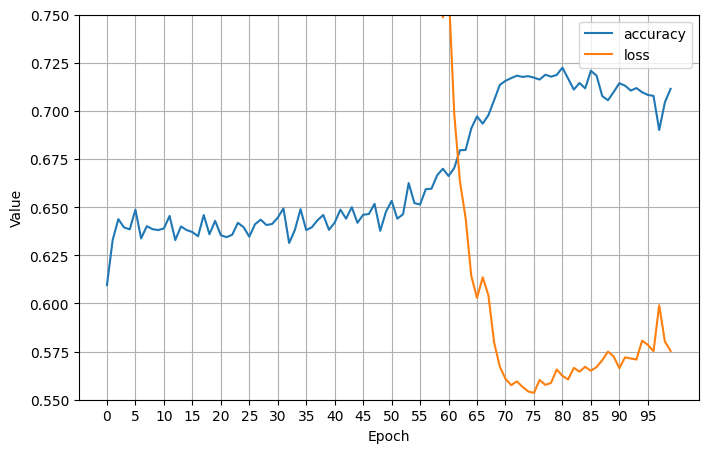

In [50]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.55, 0.75)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 100, 5.0))
plt.show()

In [51]:
# The model accuracy seems to be approaching maximum we would expect with only ten minutes of data
# But let's try more neurons and see if that improves accuracy
model_7 = tf.keras.Sequential([
  tf.keras.layers.Dense(50, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(50, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(50),
  tf.keras.layers.Dense(50),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = model_7.fit(X_train, y_train, epochs=100, verbose=1)
loss, accuracy = model_7.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6062 - loss: 124.1955
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6262 - loss: 37.1819
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6378 - loss: 30.5471
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6333 - loss: 32.7385
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6448 - loss: 28.0779
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6459 - loss: 21.6425
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6298 - loss: 18.0787
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6555 - loss: 18.8212
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6295 - loss: 17.1611
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6324 - loss: 16.4499
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6364 - loss: 19.3662
Epoch 12/100
247/247 ━━━━━━━━

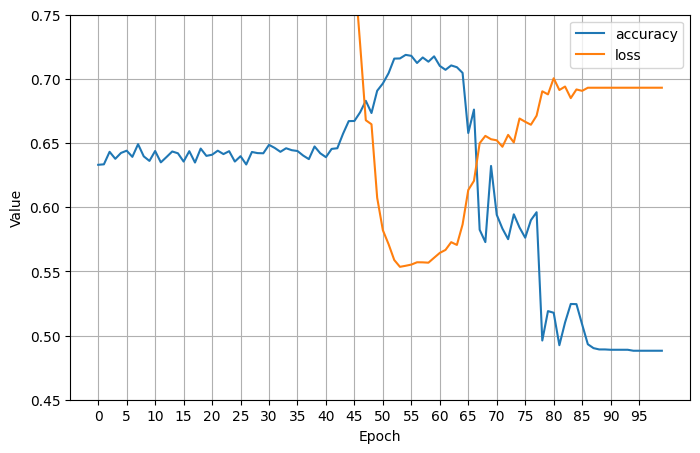

In [52]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.45, 0.75)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 100, 5.0))
plt.show()

In [53]:
# That was terrible! See if different layers help instead
model_8 = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_8.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = model_8.fit(X_train, y_train, epochs=100, verbose=1)
loss, accuracy = model_8.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6476 - loss: 65.2606
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6275 - loss: 4.1469
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6403 - loss: 2.8750
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6388 - loss: 2.6830
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6448 - loss: 2.3521
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6432 - loss: 2.0511
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6518 - loss: 1.4508
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6447 - loss: 1.2630
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6395 - loss: 1.1366
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6489 - loss: 0.9782
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6581 - loss: 0.8433
Epoch 12/100
247/247 ━━━━━━━━━━━━━━━━━━━

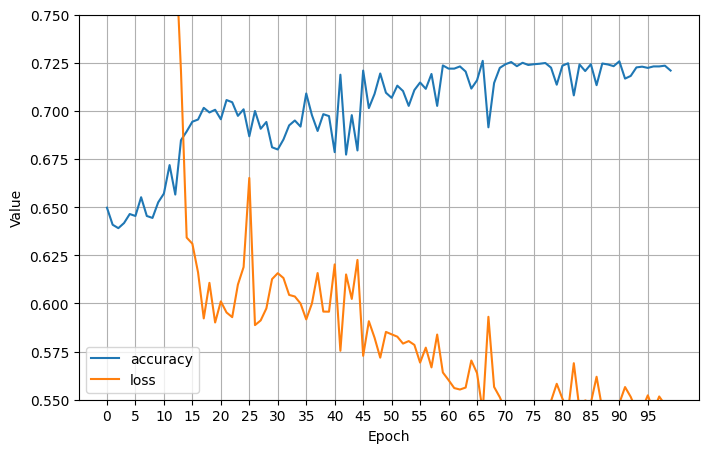

In [54]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.55, 0.75)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 100, 5.0))
plt.show()

The model accuracy seems to level off around .725% training accuracy, and achieves the same test accuracy, so it's very unlikely that we've overfitted. This is the **second best model**, only slightly underperforming QDA.

In [55]:
notebook_end_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_end_time} (duration: {notebook_end_time - notebook_start_time})")

Notebook last run (end-to-end): 2025-02-05 00:15:22.195497 (duration: 0:05:57.337681)
